In [1]:
from google.colab import drive
import torchvision.transforms as T
import torchvision.datasets as dset
import torch.optim as optim
from torch.utils.data import DataLoader, ConcatDataset, Subset
import numpy as np
import random

import torch
import torch.nn as nn
from torchvision import models, datasets, transforms
from sklearn.metrics import accuracy_score
from collections import Counter

import torch.nn.functional as F
import torchvision
import pandas as pd

import os
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix as cm
from sklearn.metrics import ConfusionMatrixDisplay
from PIL import Image
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
FOLDERPATH = 'Colab\ Notebooks/Poster/a.after_test'

In [4]:
%cd drive/MyDrive/$FOLDERPATH

/content/drive/.shortcut-targets-by-id/1OC3Immm4L7H1Rp4Po9pQSFc3-pDwQpi4/Poster/a.after_test


In [5]:

%ls

'Create train & test dataset.ipynb'   ResNet50_0929.ipynb                          val/
 EfficientNet_b0_929.ipynb            resnet50_finetuned_weights_0907_output.csv   weights/
 EfficientNet_b4_0930.ipynb           test/
 Ensemble_0930.ipynb                  train/


In [6]:
# Check if gpu is available
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")
print(f'計算裝置:{device}')

計算裝置:cuda


In [7]:
# 輸出類別數量
num_classes = 2

# 加载模型
# ResNet50
resnet = models.resnet50(pretrained=False)
resnet.fc = nn.Linear(resnet.fc.in_features, num_classes)
resnet.load_state_dict(torch.load('weights/resnet50_weights_mirrorup_0930.pth'))
resnet = resnet.to(device)

# # DenseNet121
# densenet = models.densenet121(pretrained=False)
# densenet.classifier = nn.Linear(densenet.classifier.in_features, num_classes)
# densenet.load_state_dict(torch.load('Densenet121_weights_920.pth'))
# densenet = densenet.to(device)


efficientnetb4 = models.efficientnet_b4(pretrained = False)
efficientnetb4.classifier[1] = nn.Linear(efficientnetb4.classifier[1].in_features, num_classes)
efficientnetb4.load_state_dict(torch.load('weights/EfficientNetb4_weights_mirrorup_0930.pth'))
efficientnetb4 = efficientnetb4.to(device)

# EfficientNet-B0
efficientnet = models.efficientnet_b0(pretrained=False)
efficientnet.classifier[1] = nn.Linear(efficientnet.classifier[1].in_features, num_classes)
efficientnet.load_state_dict(torch.load('weights/EfficientNetb0_weights_mirrorup_0930.pth'))
efficientnet = efficientnet.to(device)

models_list = [resnet, efficientnetb4, efficientnet]

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-7-aaaffcc17d00>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions 

In [8]:
# Load test data
transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

test_1 = datasets.ImageFolder('test', transform=transform_test)
test_2 = datasets.ImageFolder('val', transform=transform_test)

test_dataset = ConcatDataset([test_1, test_2])
NUM_NEW_TEST = len(test_dataset)
print('Number of new test:', NUM_NEW_TEST)
mini_tests = DataLoader(test_dataset, batch_size=1)
test_loader = DataLoader(test_dataset, batch_size=1)

Number of new test: 140


In [9]:
# 檢查類別索引是否一致
# print(f'測試數據的類別索引: {test_dataset.class_to_idx}')

# 定義多模型預測的函數
def ensemble_predict(models, dataloader, device, weights):
    for model in models:
        model.eval()

    all_predictions = [] # 初始化一個空列表，存儲所有的預測結果
    all_labels = [] # 初始化一個空列表，存儲所有的真實標籤

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            outputs = [] # 初始化一個空列表，存儲每個模型的輸出

            for i, model in enumerate(models):
                output = model(inputs)
                output = torch.softmax(output, dim=1)  # 轉成機率分布
                output = output * weights[i] # 將輸出乘以該模型的權重進行加權
                outputs.append(output)

            avg_output = torch.sum(torch.stack(outputs), dim=0) / sum(weights) #對所有模型的加權輸出進行加總除以權重總和，計算加權平均輸出
            _, preds = torch.max(avg_output, 1) # 返回最大值和索引,只需要索引 preds

            all_predictions.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    return all_labels, all_predictions

# 設置模型權重
weights = [0.3, 0.35, 0.35] # 依模型性能調整resnet, efficientnetb4, efficientnet

# 多模型預測
labels, predictions = ensemble_predict(models_list, test_loader, device, weights)

# 計算準確率
accuracy = accuracy_score(labels, predictions) * 100
print(f"ensemble_Acc: {accuracy:.2f}%")

# 输出的預測分布和標籤分布
print("預測分佈:", Counter(predictions))
print("標籤分佈:", Counter(labels))


ensemble_Acc: 95.71%
預測分佈: Counter({1: 73, 0: 67})
標籤分佈: Counter({1: 71, 0: 69})


## Confusion Matrix

In [11]:
# Load data
test_data_all = dset.ImageFolder('../final_5')
# test_data_1 = dset.ImageFolder('test')
# test_data_2 = dset.ImageFolder('val')
# test_data_all = ConcatDataset([test_data_1, test_data_2])
print(len(test_data_all))

# small test
# subset_indices = list(range(400))
subset_indices = list(range(len(test_data_all)))
test_data = Subset(test_data_all, subset_indices)
print(test_data[0][0])

400
<PIL.Image.Image image mode=RGB size=1433x1305 at 0x784665C135E0>


In [12]:
len(test_data)

400

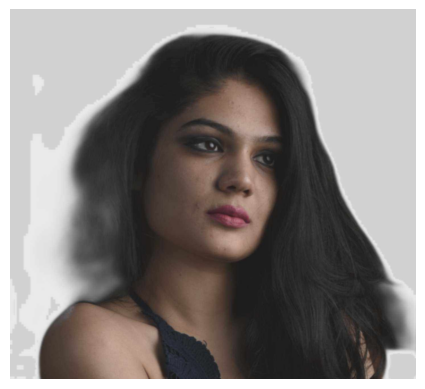

In [13]:
img, label = test_data_all[0]
plt.imshow(np.array(img))
plt.axis('off')  # 不显示坐标轴
plt.show()

In [14]:
NUM_TEST = len(test_data)
print('Number of test data:', NUM_TEST)

Number of test data: 400


In [15]:
SIZE_BEFORE_CUT = 256
CENTER_CROP = 224

In [16]:
# 把原圖的短邊調整為SIZE_BEFORE_CUT，並且保持原圖比例縮小或放大
# 一樣依照原圖比例centercrop，短邊先調整為CENTER_CROP，保持原圖比例進行centercrop
def img_transform(data, mode='None'):
  w, h = data[0].size
  y = data[1] if data[1]==0 else 1
  if w < h:
    new_img = data[0].resize((SIZE_BEFORE_CUT, int((SIZE_BEFORE_CUT/w) * h))) # 先依照比例resize (短邊 == SIZE_BEFORE_CUT)

    # 計算等等要center_crop的尺寸
    new_w, new_h = new_img.size
    center_crop_w = CENTER_CROP
    center_crop_h = int((CENTER_CROP/new_w) * new_h)
  else:
    new_img = data[0].resize((int((SIZE_BEFORE_CUT/h) * w), SIZE_BEFORE_CUT))
    new_w, new_h = new_img.size
    center_crop_w = int((CENTER_CROP/new_h) * new_w)
    center_crop_h = CENTER_CROP


# transform_tensor = T.Compose([T.CenterCrop((center_crop_h, center_crop_w)), T.ToTensor()])
  transform_tensor = T.Compose([T.Resize((224, 224)), T.ToTensor()])
  transform_centercrop = T.Compose([T.CenterCrop((center_crop_h, center_crop_w))])

  if mode == 'tensor':
    return transform_tensor(new_img), torch.tensor(y)
  else:
    return transform_centercrop(new_img)

In [17]:
bad_prediction_test = []  # 儲存錯誤預測結果
acc_count_test = 0  # 統計正確預測的個數
weights = [0.3, 0.35, 0.35]  # 設定多個模型的權重

# 設定所有模型為評估模式
for model in models_list:
    model.eval()

all_predictions = [] # 初始化一個空列表，存儲所有的預測結果
all_labels = [] # 初始化一個空列表，存儲所有的真實標籤

with torch.no_grad():
    for i in range(len(test_data)):  # 使用每張圖片進行逐張測試
        yes_or_no = 'Wrong'
        new_img, y = img_transform(test_data[i], mode='tensor')
        # 增加維度(C, H, W) -> (N, C, H, W)
        x = new_img.unsqueeze(0).to(device)  # 增加batch維度
        y = y.unsqueeze(0).to(device)  # 獲取真實標籤

        outputs = []

        for j, model in enumerate(models_list):
            output = model(x)
            output = torch.softmax(output, dim=1)  # 轉換為機率分佈
            output = output * weights[j]  # 加權模型的輸出
            outputs.append(output)

        avg_output = torch.sum(torch.stack(outputs), dim=0) / sum(weights)
        _, preds = torch.max(avg_output, 1)
        predictions = avg_output.max(1)[1]

        all_predictions.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

        if predictions.item() == y.item():
            acc_count_test += 1
            yes_or_no = 'Correct'

        print(f"Running...{yes_or_no}!  完成率{((i+1)/NUM_TEST)*100:.2f}% 目前準確率: {acc_count_test / (i+1) * 100:.2f}%")

        rate = torch.softmax(avg_output, dim=1)
        bad_prediction_test.append(
            dict(
                y_label = y.item(),
                prediction=predictions.item(),
                Portrait=rate[0][0].item(),
                SD=rate[0][1].item(),
                )
            )


# 輸出測試集的準確率
print(f"***逐張圖片測試的最終準確率: {acc_count_test / NUM_TEST * 100:.2f}%***")

Running...Wrong!  完成率0.25% 目前準確率: 0.00%
Running...Wrong!  完成率0.50% 目前準確率: 0.00%
Running...Correct!  完成率0.75% 目前準確率: 33.33%
Running...Correct!  完成率1.00% 目前準確率: 50.00%
Running...Correct!  完成率1.25% 目前準確率: 60.00%
Running...Correct!  完成率1.50% 目前準確率: 66.67%
Running...Correct!  完成率1.75% 目前準確率: 71.43%
Running...Correct!  完成率2.00% 目前準確率: 75.00%
Running...Correct!  完成率2.25% 目前準確率: 77.78%
Running...Correct!  完成率2.50% 目前準確率: 80.00%
Running...Correct!  完成率2.75% 目前準確率: 81.82%
Running...Correct!  完成率3.00% 目前準確率: 83.33%
Running...Correct!  完成率3.25% 目前準確率: 84.62%
Running...Correct!  完成率3.50% 目前準確率: 85.71%
Running...Correct!  完成率3.75% 目前準確率: 86.67%
Running...Correct!  完成率4.00% 目前準確率: 87.50%
Running...Correct!  完成率4.25% 目前準確率: 88.24%
Running...Correct!  完成率4.50% 目前準確率: 88.89%
Running...Correct!  完成率4.75% 目前準確率: 89.47%
Running...Correct!  完成率5.00% 目前準確率: 90.00%
Running...Correct!  完成率5.25% 目前準確率: 90.48%
Running...Correct!  完成率5.50% 目前準確率: 90.91%
Running...Correct!  完成率5.75% 目前準確率: 91.30%
Running...Wrong! 

In [18]:
print(f"測試資料正確率: {acc_count_test / NUM_TEST}")

測試資料正確率: 0.9025


In [19]:
accuracy = accuracy_score(all_labels, all_predictions) * 100
print(f"ensemble_Acc: {accuracy:.2f}%")

ensemble_Acc: 90.25%


In [20]:
pd.set_option('display.float_format', '{:.4f}'.format)
pd.set_option('display.max_rows', 140)
test_d = pd.DataFrame(bad_prediction_test)
test_d.loc[test_d.y_label == test_d.prediction, 'check'] ='T'
test_d

,y_label,prediction,Portrait,SD,check
0,0,1,0.3904,0.6096,NaN
1,0,1,0.4459,0.5541,NaN
2,0,0,0.6991,0.3009,T
3,0,0,0.7308,0.2692,T
4,0,0,0.7291,0.2709,T
...,...,...,...,...,...
395,1,1,0.2691,0.7309,T
396,1,1,0.2690,0.7310,T
397,1,1,0.2692,0.7308,T
398,1,1,0.3679,0.6321,T


In [21]:
output_rate = test_d.copy()

output_rate.loc[output_rate.check.isna(), 'check'] = 'F'
output_rate['y_label'].replace({0: 'Portrait', 1: 'SD'}, inplace=True)
output_rate['prediction'].replace({0: 'Portrait', 1: 'SD'}, inplace=True)

output_rate.to_csv('resnet50_finetuned_weights_0907_output.csv', sep='\t')
print(output_rate)

<ipython-input-21-38d3e51b964e>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  output_rate['y_label'].replace({0: 'Portrait', 1: 'SD'}, inplace=True)
<ipython-input-21-38d3e51b964e>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, in

      y_label prediction  Portrait     SD check
0    Portrait         SD    0.3904 0.6096     F
1    Portrait         SD    0.4459 0.5541     F
2    Portrait   Portrait    0.6991 0.3009     T
3    Portrait   Portrait    0.7308 0.2692     T
4    Portrait   Portrait    0.7291 0.2709     T
..        ...        ...       ...    ...   ...
395        SD         SD    0.2691 0.7309     T
396        SD         SD    0.2690 0.7310     T
397        SD         SD    0.2692 0.7308     T
398        SD         SD    0.3679 0.6321     T
399        SD         SD    0.4265 0.5735     T

[400 rows x 5 columns]


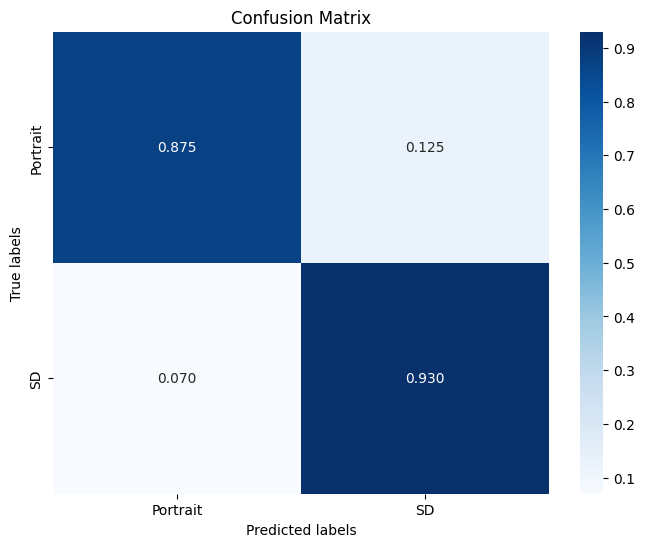

In [22]:
# Confusion Matrix
y_true = test_d.y_label
y_pred = test_d.prediction

conf_matrix = cm(y_true, y_pred, normalize='true') # 顯示佔比
plt.figure(figsize=(8, 6))
num_classes = ['Portrait', 'SD']
sns.heatmap(conf_matrix, annot=True, cmap='Blues', xticklabels=num_classes, yticklabels=num_classes, fmt='.3f')

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [23]:
test_d['check'] = test_d['check'].replace('n', np.nan)

bad_pred_index = test_d[test_d.check.isna()].index

print('錯誤分類的index:', bad_pred_index)
print('錯誤分類的數量:', len(bad_pred_index))

錯誤分類的index: Index([  0,   1,  23,  27,  28,  33,  35,  40,  50,  58,  70,  91,  98, 103,
       105, 108, 111, 122, 133, 136, 137, 155, 173, 175, 186, 247, 261, 263,
       270, 279, 281, 285, 286, 292, 294, 316, 317, 323, 329],
      dtype='int64')
錯誤分類的數量: 39


In [24]:
good_pred_index = test_d[test_d['check'] == 'T'].index

print('正確分類的index:', good_pred_index)
print('正確分類的數量:', len(good_pred_index))

正確分類的index: Index([  2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
       ...
       390, 391, 392, 393, 394, 395, 396, 397, 398, 399],
      dtype='int64', length=361)
正確分類的數量: 361


## Saliency map

In [25]:
def saliency_map(img, models, weights=None):
    x, _ = img_transform(img, mode='tensor')
    x = x.to(device).unsqueeze(0)
    x.requires_grad_()

    saliency_maps = []

    if weights is None:
        weights = [1 / len(models)] * len(models)  # 如果沒有指定權重，則進行均勻加權

    # 確保權重數量和模型數量一致
    assert len(weights) == len(models), "模型與權重數量不一致！"

    # 對每個模型進行 Saliency Map 計算
    for i, model in enumerate(models):
        model.eval()  # 設置模型為評估模式
        output = model(x)
        output_max = torch.argmax(output, dim=1)
        model.zero_grad()
        output[0, output_max].backward()

        # 計算該模型的 Saliency Map
        saliency, _ = torch.max(x.grad.data.abs(), dim=1)

        # 將 Saliency Map 乘以該模型的權重
        saliency_maps.append(saliency[0] * weights[i])

        # 清除梯度，準備下一個模型
        x.grad.zero_()

    # 合併所有模型的 Saliency Map (加權和)
    combined_saliency_map = torch.stack(saliency_maps).sum(dim=0)

    return combined_saliency_map


In [ ]:
saliency_map_lst = []
original_img_lst = []
for i in range(len(test_data)):
    # 取得Saliency map
    sm_img = saliency_map(test_data[i], models_list, weights)
    saliency_map_lst.append(sm_img)
    # 取得原圖
    img = img_transform(test_data[i])
    original_img_lst.append(img)

# 確認saliency_map_lst的照片大小
print('saliency_map:', saliency_map_lst[0].shape) # (H, W)
# 確認original_img_lst的照片大小
print('original_img:', original_img_lst[0].size) # (W, H)

In [ ]:
col = 3
row = len(bad_pred_index)

# Create subplots
fig, axes = plt.subplots(row, col, figsize=(8, row * 3) if row > 1 else (8, 6))

# Check if axes is 1D or 2D
if row == 1:
    axes = np.expand_dims(axes, axis=0)  # Convert to 2D if only one row

for i in range(len(bad_pred_index)):
    # 獲取 Saliency map 的尺寸
    saliency_map = saliency_map_lst[bad_pred_index[i]].cpu().numpy()

    # 畫出 Saliency map
    ax = axes[i, 0]
    ax.set_title(f'Y_label: {output_rate.y_label[bad_pred_index[i]]}, Pred : {output_rate.prediction[bad_pred_index[i]]}', fontsize=8, y=-0.1)
    ax.imshow(saliency_map, cmap=plt.cm.hot)
    ax.axis('off')

    # 畫出原圖並調整其尺寸與 Saliency map 匹配
    ax = axes[i, 1]
    original_img = original_img_lst[bad_pred_index[i]]

    # Resize 原圖到與 Saliency map 一樣的大小
    resized_img = np.array(original_img.resize(saliency_map.shape[1::-1]))  # Resize to match the saliency map dimensions
    ax.imshow(resized_img)
    ax.axis('off')

    # 疊加圖像
    ax = axes[i, 2]
    ax.imshow(resized_img, alpha=0.75)  # 使用調整後的圖像
    ax.imshow(saliency_map, cmap=plt.cm.hot, alpha=0.8)  # 疊加 Saliency map
    ax.axis('off')

# 調整圖像的間距
plt.tight_layout()
plt.show()


In [ ]:
# col = 3
# row = len(bad_pred_index)

# # fig, axes = plt.subplots(row, col, figsize=(8, row*3))

# # Create subplots
# fig, axes = plt.subplots(row, col, figsize=(8, row*3) if row > 1 else (8, 6))

# # Check if axes is 1D or 2D
# if row == 1:
#     axes = np.expand_dims(axes, axis=0)  # Convert to 2D if only one row

# for i in range(len(bad_pred_index)):
#     # 畫出Saliency map
#     ax = axes[i, 0]
#     ax.set_title(f'Y_label: {output_rate.y_label[bad_pred_index[i]]}, Pred : {output_rate.prediction[bad_pred_index[i]]}', fontsize=8, y=-0.1)
#     ax.imshow(saliency_map_lst[bad_pred_index[i]].cpu().numpy(), cmap=plt.cm.hot)
#     ax.axis('off')

#     # 畫出原圖(有經過center_crop的)
#     ax = axes[i, 1]
#     ax.imshow(original_img_lst[bad_pred_index[i]])
#     ax.axis('off')

#     # 疊加圖像
#     ax = axes[i, 2]  # 第三列用於疊加圖像
#     ax.imshow(original_img_lst[bad_pred_index[i]], alpha=0.75)  # 設置透明度
#     ax.imshow(saliency_map_lst[bad_pred_index[i]].cpu().numpy(), cmap=plt.cm.hot, alpha=0.75)  # 疊加 Saliency map
#     ax.axis('off')

In [ ]:
# for i in range(len(bad_pred_index)):
#     # 画出 Saliency map
#     ax = axes[i, 0]
#     ax.set_title(f'Y_label: {output_rate.y_label[bad_pred_index[i]]}, Pred : {output_rate.prediction[bad_pred_index[i]]}', fontsize=8, y=-0.1)
#     ax.imshow(saliency_map_lst[bad_pred_index[i]].cpu().numpy(), cmap=plt.cm.hot)
#     ax.axis('off')

#     # 画出原图(有经过 center_crop 的)
#     ax = axes[i, 1]
#     ax.imshow(original_img_lst[bad_pred_index[i]])
#     ax.axis('off')

#     # 叠加图像
#     ax = axes[i, 2]  # 假设你有第三列用于叠加图像
#     ax.imshow(original_img_lst[bad_pred_index[i]], alpha=0.5)  # 设置透明度
#     ax.imshow(saliency_map_lst[bad_pred_index[i]].cpu().numpy(), cmap=plt.cm.hot, alpha=0.5)  # 叠加 Saliency map
#     ax.axis('off')

In [ ]:
batch_size = 20  # 每批最多显示 20 行
for start in range(0, len(good_pred_index), batch_size):
    end = min(start + batch_size, len(good_pred_index))
    row = end - start

    fig, axes = plt.subplots(row, col, figsize=(8, row * 2))

    if row == 1:
        axes = np.expand_dims(axes, axis=0)  # 处理单行的情况

    for i, idx in enumerate(good_pred_index[start:end]):
        # 绘制 Saliency map 和原图的代码
        saliency_map = saliency_map_lst[idx].cpu().numpy()

        ax = axes[i, 0]
        ax.set_title(f'Y_label: {output_rate.y_label[idx]}, Pred : {output_rate.prediction[idx]}', fontsize=8, y=-0.1)
        ax.imshow(saliency_map, cmap=plt.cm.hot)
        ax.axis('off')

        ax = axes[i, 1]
        original_img = original_img_lst[idx]
        resized_img = np.array(original_img.resize(saliency_map.shape[1::-1]))
        ax.imshow(resized_img)
        ax.axis('off')

        ax = axes[i, 2]
        ax.imshow(resized_img, alpha=0.75)
        ax.imshow(saliency_map, cmap=plt.cm.hot, alpha=0.8)
        ax.axis('off')

    plt.tight_layout()
    plt.show()
